In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib



In [ ]:

# Load and clean data
df = pd.read_csv("../../data/Salary_Data.csv")

# Remove missing values
df.dropna(inplace=True)

# Check and remove duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows before removal: {duplicates}")

df.drop_duplicates(inplace=True)
print("Duplicates removed successfully.")

print(f"Number of duplicate rows after removal: {df.duplicated().sum()}")


conversion_rate_inr_to_lkr = 4.6

# Convert Salary to LKR
df['Salary_LKR'] = df['Salary'] * conversion_rate_inr_to_lkr
print(df[['Salary', 'Salary_LKR']].head())



Number of duplicate rows before removal: 4911
Duplicates removed successfully.
Number of duplicate rows after removal: 0
     Salary  Salary_LKR
0   90000.0    414000.0
1   65000.0    299000.0
2  150000.0    690000.0
3   60000.0    276000.0
4  200000.0    920000.0


In [3]:
# Function to remove outliers using IQR
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers in Salary only
numerical_cols_salary = ['Salary']
df_cleaned = remove_outliers_iqr(df, numerical_cols_salary)
df_cleaned = df_cleaned[df_cleaned['Salary'] > 1000]  # Keep realistic salaries
df_cleaned = df_cleaned.reset_index(drop=True)

print(f"Original rows: {len(df)}, Cleaned rows: {len(df_cleaned)}")




Original rows: 1787, Cleaned rows: 1783


In [4]:
# Split features and target
X = df_cleaned.drop('Salary', axis=1)
y = df_cleaned['Salary']

# Stratified split on Gender to maintain distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X['Gender']
)



In [5]:
# Handle rare categories
threshold = 10
for col in ['Job Title', 'Education Level']:
    top_categories = X_train[col].value_counts().loc[lambda x: x >= threshold].index
    X_train[col] = X_train[col].where(X_train[col].isin(top_categories), 'Other')
    X_test[col] = X_test[col].where(X_test[col].isin(top_categories), 'Other')

# Preprocessing pipeline
numerical_cols = ['Age', 'Years of Experience']
categorical_cols = ['Gender', 'Education Level', 'Job Title']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# Random Forest model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=4,
        max_features='sqrt',
        random_state=42
    ))
])

# K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
print(f"Mean CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Fit model
model.fit(X_train, y_train)



/opt/conda/envs/ml-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Mean CV R²: 0.815 (+/- 0.044)


,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [6]:

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation function
def evaluate_detailed(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"RMSE: LKR {rmse:,.2f}")
    print(f"R²: {r2:.3f}")
    print(f"MAE: LKR {mae:,.2f}")
    
    return rmse, r2, mae

train_metrics = evaluate_detailed(y_train, y_train_pred, "Training")
test_metrics = evaluate_detailed(y_test, y_test_pred, "Testing")




Training Metrics:
RMSE: LKR 19,941.18
R²: 0.848
MAE: LKR 15,638.38

Testing Metrics:
RMSE: LKR 22,215.04
R²: 0.817
MAE: LKR 17,467.10


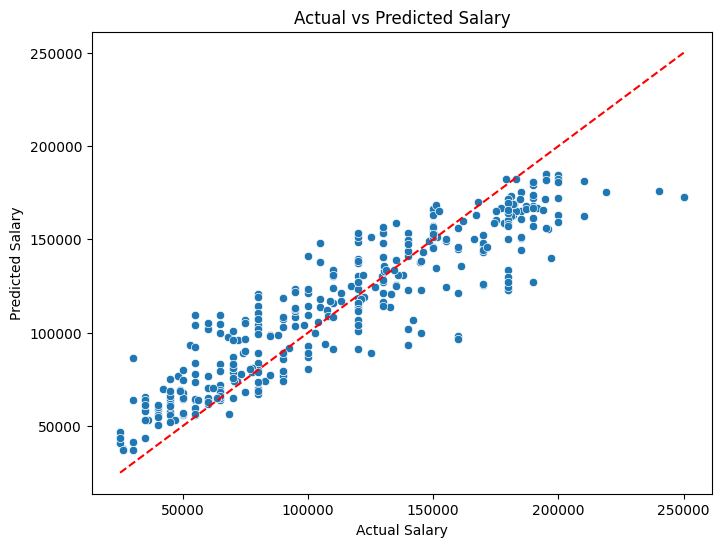

In [7]:
# Plot: Actual vs Predicted salaries
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary")
plt.show()



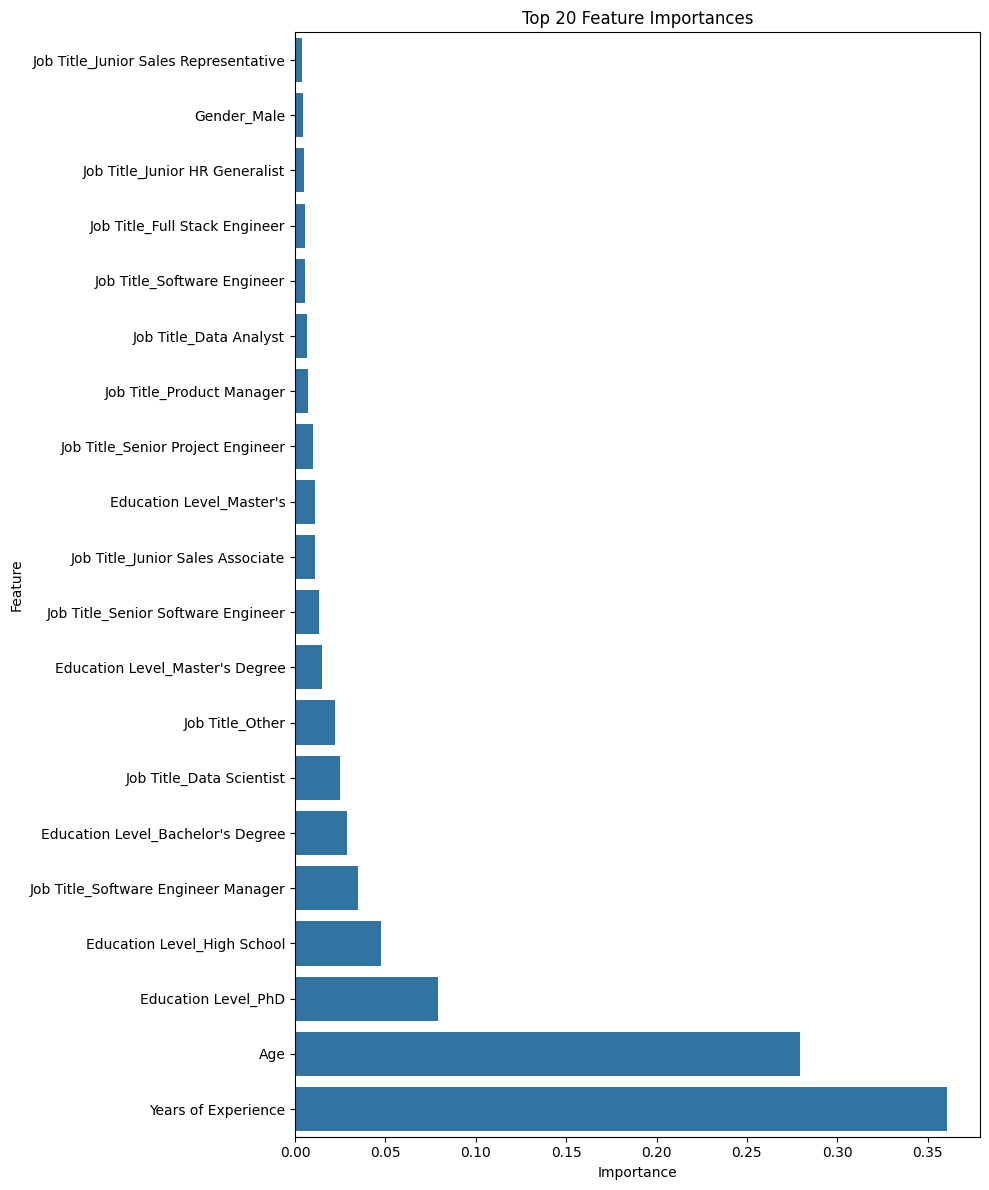

In [8]:

# Extract RandomForest regressor from pipeline
reg = model.named_steps['regressor']

# Get numeric + one-hot encoded feature names
cat_features = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_features)
importances = reg.feature_importances_

# Create Series and sort
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# Plot top 20 features for clarity
top_n = 20
plt.figure(figsize=(10, 0.5*top_n + 2))  # Dynamically adjust figure height
sns.barplot(x=feat_imp.values[-top_n:], y=feat_imp.index[-top_n:])
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



In [9]:
# Predict salary for new input
# Example input
new_employee = pd.DataFrame({
    'Age': [30],
    'Years of Experience': [5],
    'Gender': ['Male'],
    'Education Level': ['Bachelor'],
    'Job Title': ['Data Analyst']
})

predicted_salary = model.predict(new_employee)[0]
print(f"\nPredicted Salary for the new employee: LKR {predicted_salary:,.2f}")


Predicted Salary for the new employee: LKR 101,818.13


/opt/conda/envs/ml-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
